# Neuroscience 🧠 using fastplotlib 🦜

This notebook will build up a complex visualization using `fastplotlib`, in conjunction with `pynapple`, to show how `fastplotlib` can be a powerful tool in analysis and visualization of neural data!

In [10]:
import fastplotlib as fpl
import pynapple as nap
import numpy as np
from ipywidgets import IntSlider, Layout, VBox, HBox, FloatSlider
from sidecar import Sidecar
from store_model import TimeStore

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load the data

#### Recording of a freely-moving mouse imaged with a Miniscope (1-photon imaging). The area recorded is the postsubiculum - a region that is known to contain head-direction cells, or cells that fire when the animal's head is pointing in a specific direction.

In [4]:
data = nap.load_file("./data.nwb")

In [5]:
data

data
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ position_time_support │ IntervalSet │
│ RoiResponseSeries     │ TsdFrame    │
│ calcium_video         │ TsdTensor   │
│ beh_video             │ TsdTensor   │
│ z                     │ Tsd         │
│ y                     │ Tsd         │
│ x                     │ Tsd         │
│ rz                    │ Tsd         │
│ ry                    │ Tsd         │
│ rx                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

### Let's view the behavior and calcium data

**NOTE:** We are going to be using a WIP `TimeStore` model to help synchronize our visualization in time. 

In [11]:
time_store = TimeStore()

Behavior data and shape 🐭

In [12]:
behavior_data = data["beh_video"]
behavior_data.shape  # (time, x, y)

(9045, 204, 256)

Calcium data and the shape 🔬

In [13]:
calcium_data = data["calcium_video"]
calcium_data.shape  # (time, x, y)

(17886, 136, 166)

#### Set our view of the data to where both behavior and position data are available:

In [14]:
behavior_data = behavior_data.restrict(data["position_time_support"])
calcium_data = calcium_data.restrict(data["position_time_support"])

(data["position_time_support"].start[0], data["position_time_support"].end[0])

(np.float64(7.39305), np.float64(1213.22765))

RFBOutputContext()

JupyterWgpuCanvas()
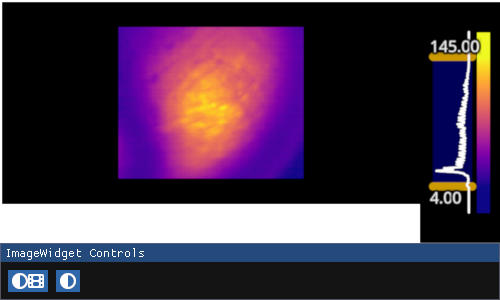

In [24]:
# calculate min frame across movie
# remove vignette effect from 1p endoscopic imaging
min_frame = calcium_data.min(axis=0)

# just to show you what this looks like
iw = fpl.ImageWidget(min_frame)
iw.show()

In [25]:
iw.close()

## Create a big viz for calcium and behavior video! 🎨

In [26]:
# make figure, calcium on left, behavior on right
nap_figure = fpl.Figure(shape=(1,2), names=[["calcium", "behavior"]])

# image graphic to display current calcium frame
calcium_graphic = nap_figure["calcium"].add_image(data=calcium_data[0] - min_frame, name="calcium_frame", cmap="gnuplot2")

# a UI tool to help set and visualize vmin-vmax
hlut = fpl.HistogramLUTTool(data=calcium_data, image_graphic=calcium_graphic)
# add this to the right dock
nap_figure["calcium"].docks["right"].add_graphic(hlut)
nap_figure["calcium"].docks["right"].size = 80
nap_figure["calcium"].docks["right"].auto_scale(maintain_aspect=False)
nap_figure["calcium"].docks["right"].controller.enabled = False

# image graphic to display current behavior video frame
behavior_graphic = nap_figure["behavior"].add_image(data=behavior_data[0], cmap="gray")

# line to display the behavior tracks
#tracks_graphic = nap_figure["behavior"].add_line(tracks_data, cmap="winter", thickness=2, alpha=0.5, offset=(12, 0, 2))

RFBOutputContext()

#### Create a slider that updates the behavior and calcium videos using `pynapple`

In [27]:
# This time will be in seconds
synced_time = FloatSlider(min=data["position_time_support"].start, max=data["position_time_support"].end, step=0.01, description="s")

# auto-resize slider
@nap_figure.renderer.add_event_handler("resize")
def resize_slider(ev):
    synced_time.layout = Layout(width=f"{ev.width}px")

#### Add the components of our visualization to the `TimeStore` model to be synchronized 🕰️

In [28]:
# add the slider
time_store.subscribe(subscriber=synced_time)

def substract_min(frame):
    """subtract min frame from current frame"""
    global min_frame

    return frame - min_frame

# add our calcium data
time_store.subscribe(subscriber=calcium_graphic, data=calcium_data, data_filter=substract_min)

# add our behavior data
time_store.subscribe(subscriber=behavior_graphic, data=behavior_data)

**Here we are going to use `sidecar` to organize our visualizations better :D**

In [29]:
sc = Sidecar()
with sc:
    display(VBox([nap_figure.show(), synced_time]))